In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

# Making 2 Folders for test and train

In [30]:
dataset_path ='/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/'

In [39]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all files with class subdirectories
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_path) for f in filenames]

# Split the data
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Copy the files into subdirectories by class
for file in train_files:
    class_name = os.path.basename(os.path.dirname(file))  # Extracts 'Parasitized' or 'Uninfected'
    dest_dir = os.path.join(train_dir, class_name)  # Creates path like '/kaggle/working/train/Parasitized'
    os.makedirs(dest_dir, exist_ok=True)  # Creates the directory if it doesn't exist
    shutil.copy(file, dest_dir)  # Copies the image to the correct class folder

for file in test_files:
    class_name = os.path.basename(os.path.dirname(file))
    dest_dir = os.path.join(test_dir, class_name)
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(file, dest_dir)

# Visualization

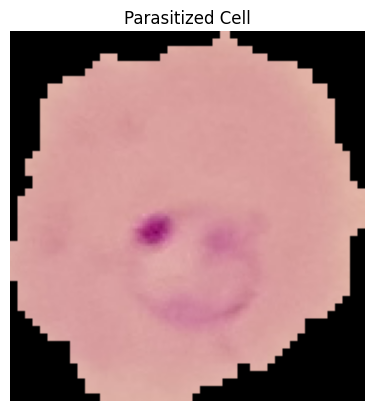

In [22]:
infected_img = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
infected_img_rgb = cv2.cvtColor(infected_img, cv2.COLOR_BGR2RGB)
plt.imshow(infected_img_rgb)
plt.axis('off')
plt.title("Parasitized Cell")
plt.show()

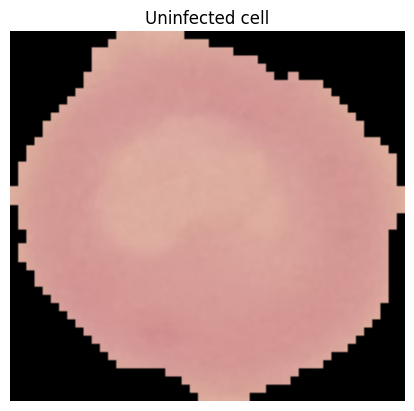

In [33]:
uninfected_cell = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png')
uninfected_cell_rgb = cv2.cvtColor(uninfected_cell, cv2.COLOR_BGR2RGB)
plt.imshow(uninfected_cell_rgb)
plt.title('Uninfected cell')
plt.axis('off')
plt.show()

In [20]:
image_classes = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/')
print(image_classes)

['Uninfected', 'Parasitized']


In [31]:
def plot_images(image_classes):
    plt.figure(figsize = (8,8))
    for i, category in enumerate(image_classes):
        image_path = dataset_path + "/" + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + "/" + first_image
        
        #load image
        img = image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(1, 2, i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

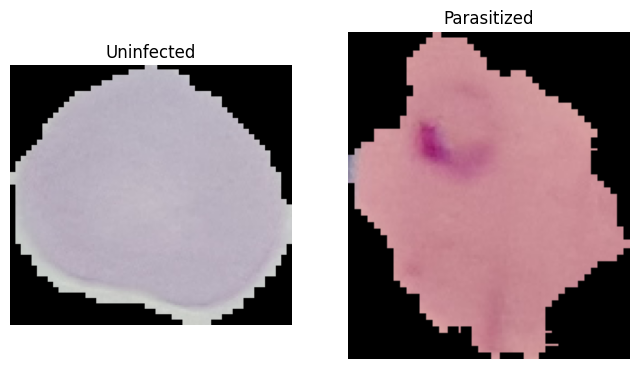

In [32]:
plot_images(image_classes)

# Data Processing and Splitting

In [54]:
data_generator = ImageDataGenerator( rescale = 1/255, validation_split=0.2 )

In [55]:
train_data = data_generator.flow_from_directory(train_dir,
                                                target_size = (150,150),
                                               batch_size = 16,
                                               subset = 'training')

Found 17639 images belonging to 2 classes.


In [57]:
val_data =  data_generator.flow_from_directory(train_dir,
                                               target_size = (150,150),
                                               batch_size = 16,
                                               subset = 'validation')

Found 4408 images belonging to 2 classes.


In [41]:
test_data = data_generator.flow_from_directory(test_dir,
                                               target_size = (150,150),
                                               batch_size = 16)

Found 5511 images belonging to 2 classes.


# CNN Model Building

In [128]:
model = Sequential([
    
    Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu',
           input_shape = [150,150,3]),
    MaxPooling2D(),
    
    Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    
    Dropout(0.2),
    
    Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    
    Dropout(0.2),
    
    Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),

    Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(2, activation = 'softmax')
    
],name = 'CNN_MALARIA')

In [129]:
model.summary()

Model: "CNN_MALARIA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 150, 150, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 37, 37, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 9, 9, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,770 (768.63 KB)

 Trainable params: 196,770 (768.63 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [131]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 7,
    restore_best_weights = True
)

In [132]:
model_history = model.fit(train_data, epochs = 100, callbacks = [early_stopping], validation_data = val_data)


Epoch 1/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.7296 - loss: 0.4573 - val_accuracy: 0.9510 - val_loss: 0.1667
Epoch 2/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9572 - loss: 0.1501 - val_accuracy: 0.9499 - val_loss: 0.1701
Epoch 3/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9551 - loss: 0.1476 - val_accuracy: 0.9347 - val_loss: 0.1923
Epoch 4/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9584 - loss: 0.1389 - val_accuracy: 0.9512 - val_loss: 0.1517
Epoch 5/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9593 - loss: 0.1326 - val_accuracy: 0.9508 - val_loss: 0.1475
Epoch 6/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9612 - loss: 0.1277 - val_accuracy: 0.9494 - val_loss: 0.1571
Epoch 7/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9614 - loss: 0.1268 - val_accuracy: 0.9530 - val_loss: 0.1477
Epoch 8/100
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 

# Model Evaluation

In [133]:
training_loss, training_accuracy = model.evaluate(train_data)
print(f'Training Loss : {training_loss}')
print(f'Training Accuracy : {training_accuracy}')

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9670 - loss: 0.0984
Training Loss : 0.09518232941627502
Training Accuracy : 0.96779865026474


In [134]:
testing_loss, testing_accuracy = model.evaluate(test_data)
print(f'Testing Loss : {testing_loss}')
print(f'Testing Accuracy : {testing_accuracy}')

345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9628 - loss: 0.1201
Testing Loss : 0.12434632331132889
Testing Accuracy : 0.9622573256492615


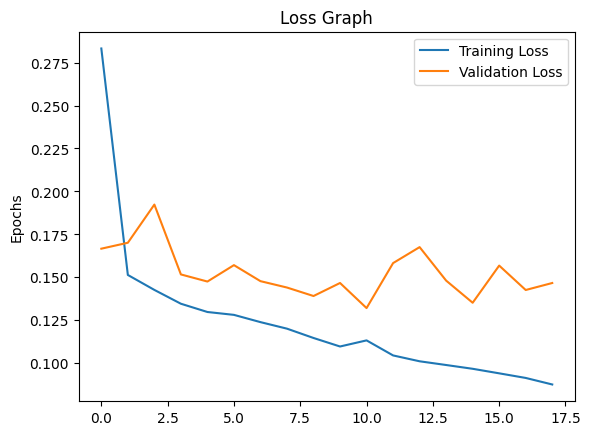

In [135]:
plt.plot(model_history.history['loss'], label = 'Training Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.show()

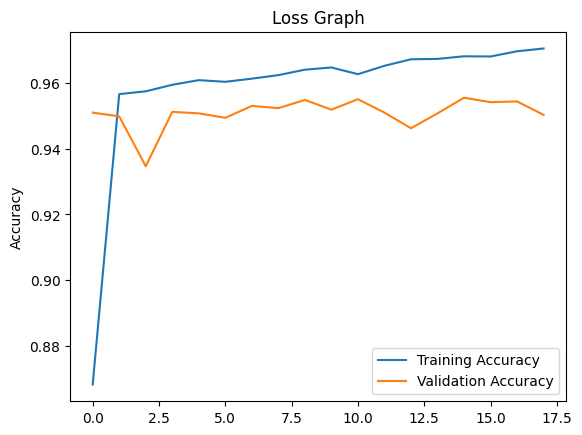

In [137]:
plt.plot(model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Loss Graph')
plt.ylabel('Accuracy')
plt.show()

## Evaluation of a selected image with visualization

In [ ]:
class_map = {}

for class_name, class_index in train_data.class_indices.items():
    # Swap the keys and values
    class_map[class_index] = class_name

print(class_map)

In [125]:
class_map = ['Parasitized', 'Uninfected']

In [126]:
def prediction(test_image, actual_label):
    #load & Preprocessing image
    testing_image = image.load_img(test_image, target_size=(150,150))
    testing_image_array = image.img_to_array(testing_image) / 255
    testing_image_input = testing_image_array.reshape(1, testing_image_array.shape[0],
                                                     testing_image_array.shape[1],
                                                     testing_image_array.shape[2])
    predicted_class = np.argmax(model.predict(testing_image_input))
    predicted_label = class_map[predicted_class]
    plt.figure(figsize = (4,4))
    plt.imshow(testing_image_array)
    plt.title('Actual Label: {}, Predicted Label: {}'.format(actual_label, predicted_label))
    plt.grid()
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


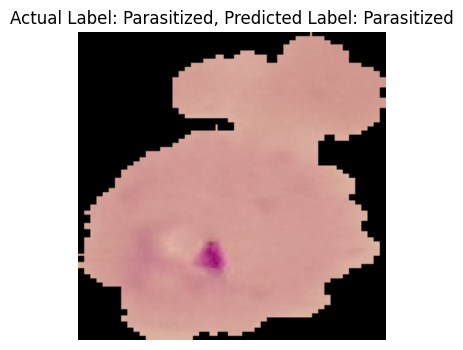

In [138]:
test_image = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png'
prediction(test_image, actual_label = 'Parasitized')